## SO - Laboratorio de Escalonamento 2 ##


Neste laboratório, iremos simular o funcionamento de algoritmos de escalonamento básicos para entender melhor seu funcionamento.

Na célula abaixo, temos uma classe Processo, que tem as informações de execução, e uma classe de exemplo de escalonamento apenas com os protótipos:

(orientação a objeto em Python)

Alunas: 
- Brenda Aguiar
- Jessica Brito

In [108]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [109]:
class Processo(object):
    def __init__(self,pnome,pio,ptam,prioridade,tempoChegada, estadoProc=0):
        self.nome = pnome
        self.io = pio # Probabilidade de fazer E/S, inicialmente zero
        self.tam = ptam # Quantos Timeslices sao necessarios para terminar
        self.prio = prioridade # Prioridade, eh desnecessaria aora
        self.chegada = tempoChegada # Tempo de chegada
        self.tmpBloq = -1
        self.tempoEspera = 0
        self.estado = estadoProc # estados do processo
        self.caminhada = 0
        self.tempoResposta = None # Tempo de Resposta do Processo
        self.tempoExecucao = None # Tempo de execução do processo

    def roda(self,quantum=None): # se rodar sem quantum, o processor roda ate o fim        
        if(random.randint(1,100)<self.io): #Verifica se fez E/S
            self.tam-=1
            self.estado = 3
            print(self.nome," fez e/s, falta ",self.tam)
            return 1, True #True que fez E/S
            
        if(quantum is None or self.tam<quantum):
            quantum = self.tam
            
        self.tam -=quantum
        print(self.nome," rodou por ",quantum," timeslice, faltam ",self.tam)
        if (self.tam == 0):
            self.estado = 4
        return quantum, False # False se nao fez E/S

In [110]:
class escalonador(object):
    def __init__(self,vprontos=[], tempoBloq=2):
        self.prontos = vprontos 
        self.temposExecucao = []
        self.temposResposta = []
        self.tmpBloq = tempoBloq

    def pronto(self,processo):
        pass
        
    def proximo(self):
        if len(self.prontos) > 0:
            return self.prontos[0]
        else:
            return None
        
    # Bloqueia o processo atual
    def bloquear(self, tempoBloq):
        self.prontos[0].tmpBloq = tempoBloq
        self.bloqueados.append(self.prontos[0])
        self.done()
        
    def feito(self):
        del(self.prontos[0])
        
    def turnaround(self):
        return np.mean(self.temposExecucao)
    
    def tempoRespostaMedio(self):
        return np.mean(self.temposResposta)
    
    def addTempoResposta(self, tempo):
        self.temposResposta.append(tempo)
    
    def addTempoExecucao(self, tempo):
        self.temposExecucao.append(tempo)

Na célula abaixo, são criados quatro processos completamente CPU-Bound que precisam de 3 timeslices para rodar.

O valor de E/S é um número entre 0 e 100 indicando quantos porcento de chance o processo tem de fazer E/S durante seu tempo na CPU

Na célula abaixo, temos o mesmo simulador do laboratório anterior:

Nesta, temos um simulador avançado, com E/S e novos processos chegando em momentos diferentes:

### Laboratório: ###

Neste laboratório vocês (em duplas) irão implementar 3 escalonadores:

1 - MLFQ: Adicione parâmetros para definir o número de filas, o quantum de cada uma e o tempo de boost.

2 - Loteria: tem um atributo `prioridade` no Processo, use ele para definir um número aleatório de bilhetes, similar ao que ocorre com e/s e outros parämetros

3 - Stride: Similar ao loteria.



## MLFQ

In [111]:
# class round robin
class RoundRobin(escalonador): 
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        if (vprontos == []):
            self.atual = 0
        else:
            self.atual = -1
        
    def pronto(self,processo):
        processo.estado = 1
        self.prontos.append(processo)
        
    def proximo(self):
        try:
            self.atual+=1
            proc = self.prontos[self.atual]
        except:
            self.atual = 0
            proc = self.prontos[self.atual]
        return proc
        
    def done(self):
        del(self.prontos[self.atual])
        try:
            self.atual-=1
            self.prontos[self.atual]
        except:
            self.atual = 0
            
    def cair(self):
        self.prontos[self.atual].prio += 1
        del(self.prontos[self.atual])
        if(self.atual == 0):
            self.atual = -1
        else :
            self.atual -= 1

In [112]:
class MLFQ(escalonador) :
    def __init__(self,vprontos = [], numListas = 1, quantum = [], t_boost = 2):
        super().__init__(vprontos, tempoBloq)
        self.numListas = numListas
        self.t_boost = t_boost
        self.quantum = quantum
        self.x = 0
        
        self.prontos = []
        esc = RoundRobin(vprontos)
        for i in range(self.numListas):
            self.prontos.append(esc)
            esc = RoundRobin([])
    
    def pronto(self,processo):
        self.prontos[processo.prio].pronto(processo)
        if (self.x < processo.prio):
            self.x = processo.prio
            
            
    def proximo(self,anteriorFezIO=False):
        if (not anteriorFezIO and self.prontos[self.x].atual!=-1 and self.prontos[self.x].prontos[self.prontos[self.x].atual].estado!=3 and self.x<len(self.prontos)-1):
            proc = self.prontos[self.x].prontos[self.prontos[self.x].atual]
            self.prontos[self.x+1].pronto(proc)
            self.prontos[self.x].cair()
            
        for i in range(len(self.prontos)):
            aux = self.prontos[i].proximo()
            if(aux is not None):
                self.x = i
                return aux
        self.x = 0
        return None
        
    def boost(self) :
        self.x = 0
        for i in range(1,len(self.prontos)) :
            while len(self.prontos[i].prontos) > 0 :
                self.prontos[i].prontos[0].prio = 0
                self.prontos[0].pronto(self.prontos[i].prontos[0])
                del(self.prontos[i].prontos[0])
                
    
    def bloquear(self):
        self.prontos[self.x].bloquear()
        if (len(self.prontos[self.x].prontos) == 0 and numListas > 1 and self.x != numListas-1):
            self.x+=1
        
    def done(self):
        self.prontos[self.x].done()
        if (len(self.prontos[self.x].prontos) == 0 and numListas > 1):
            self.x+=1
            if(self.x >= self.numListas):
                self.x = 0

## Loteria


In [113]:
class Loteria(escalonador):
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        self.atual=-1
        self.totalTickets = sum([self.prontos[i].prio for i in range(len(self.prontos))])
        self.temposEspera = []
    
    def pronto(self,processo):
        processo.estado = 1
        self.totalTickets += processo.prio
        for i in range(len(self.prontos)):
            if self.prontos[i].prio < processo.prio:
                self.prontos.insert(i, processo)
                return
        self.prontos.append(processo)
        
    def proximo(self):
        if (len(self.prontos) > 0):
            premiado = random.randint(0,self.totalTickets-1)
            print(f'\n Premiado = {premiado}')
            ticket = 0
            for i in range(len(self.prontos)):
                ticket += self.prontos[i].prio
                if premiado < ticket:
                    self.atual=i
                    return self.prontos[i]
        else:
            return None
    
    def done(self):
        self.temposEspera.append(self.prontos[self.atual].tempoEspera)
        self.totalTickets -= self.prontos[self.atual].prio
        self.prontos[self.atual].estado = 4
        del(self.prontos[self.atual])
    
    def bloquear(self):
        self.totalTickets -= self.prontos[self.atual].prio
        self.prontos[self.atual].estado = 3
        del(self.prontos[self.atual])
            
    def esperar(self, tempo):
        for i in range(len(self.prontos)):
            if (i != self.atual):
                self.prontos[i].tempoEspera+=tempo

## Stride


In [114]:
class Stride(escalonador):
    def __init__(self,vprontos=[]):
        super().__init__(vprontos)
        self.atual=-1
        self.temposEspera = []
    
    def pronto(self,processo):
        processo.estado = 1
        for i in range(len(self.prontos)):
            if self.prontos[i].prio < processo.prio:
                self.prontos.insert(i, processo)
                return
        self.prontos.append(processo)
        
    def proximo(self):
        if (len(self.prontos) > 0):
            proximo = 0
            for i in range(1,len(self.prontos)):
                if self.prontos[i].caminhada < self.prontos[proximo].caminhada:
                    proximo = i
            self.prontos[proximo].caminhada += 1000//self.prontos[proximo].prio
            self.atual = proximo
            return self.prontos[proximo]
        else:
            return None
    
    def done(self):
        self.temposEspera.append(self.prontos[self.atual].tempoEspera)
        self.prontos[self.atual].estado = 4
        del(self.prontos[self.atual])
    
    def bloquear(self):
        self.prontos[self.atual].estado = 3
        del(self.prontos[self.atual])
            
    def esperar(self, tempo):
        for i in range(len(self.prontos)):
            if (i != self.atual):
                self.prontos[i].tempoEspera+=tempo

Funções para chamar os escalonaores

In [115]:
def chamaEscalonador(nomeEscalonador, procs, quantum=None):
    # Escolhe o escalonador
    if (nomeEscalonador == "loteria"):
        escalonador = Loteria(procs) #troque escalonador pelo seu escalonador
    elif (nomeEscalonador == "stride"):
        escalonador = Stride(procs) #troque escalonador pelo seu escalonador
    elif (nomeEscalonador == "mlfq"):
        escalonador = MLFQ(procs) #troque escalonador pelo seu escalonador
        quantum = 1
    else:
        escalonador = RoundRobin(procs) #troque escalonador pelo seu escalonador
    return escalonador, nomeEscalonador, quantum

In [116]:
def rodaEscalonador(escalonador, nomeEscalonador, quantum, semente):
    bloqueados = []
    unfairness = 0.00
    tempo = 0
    random.seed(semente)
    
    print(f'################# {nomeEscalonador.upper()} ######################')
    while len(escalonador.prontos) > 0:
        p = escalonador.proximo()
        if(p is not None):
            rodou, _ = p.roda(quantum) #adicione quantum como parâmetro, por enquanto nao temos E/S
            if(p.estado == 0):
                escalonador.pronto(p)
            elif (p.tempoResposta == None):
                p.tempoResposta = tempo - p.chegada
                escalonador.addTempoResposta(p.tempoResposta)
                print(f'| Tempo de Resposta({p.nome}) = {p.tempoResposta} |')
            tempo+=rodou
            if (p.estado == 4) :
                p.tempoExecucao = tempo - p.chegada
                escalonador.addTempoExecucao(p.tempoExecucao)
                print(f'| Tempo de Execução({p.nome}) = {p.tempoExecucao} | \n')
                escalonador.done()
        else:
            print(" > +1 timeslice")
            tempo+=1
    
    unfairness = round( escalonador.temposExecucao[0]/escalonador.temposExecucao[1],2)
    print(f'Turnaround = {escalonador.turnaround()}')
    print(f'Tempo de resposta = {escalonador.tempoRespostaMedio()}')
    return escalonador.turnaround(), escalonador.tempoRespostaMedio(), unfairness



In [117]:
def escalonar(nomeEscalonador, procs, quantum=None, semente=0):
    esc, nomeEscalonador, quantum = chamaEscalonador(nomeEscalonador, procs, quantum)
    turnaround, rm, unfairness = rodaEscalonador(esc, nomeEscalonador, quantum, semente)
    return rm, unfairness

In [118]:
def chamaProcs(nprocs, nomes, chanceio, tamanho, tickets):
    total = tamanho.sum()
    procs = []
    for i in range(nprocs):
        procs.append(Processo(nomes[i],chanceio[i],tamanho[i],tickets[i],0,1)) #cria uma lista procs de Processos
    return procs

## Responda ##

#### Sobre Loteria: ####

1 - Rode a simulação mais simples com apenas dois processos, um com 100 tickets e outro com 1, com tempo 100 para terminar. O que aconteceu? O segundo processo conseguiu rodar alguma vez? Testando com outras sementes o resultado se manteve?


<b> R: O processo A com ticket 100 (o que estava com mais ticket) rodou até o final e só deixou o processo com 1 ticket rodar quando finalizou. Ao mudar a semente para outros valores o resultado se manteve. <b/>


In [119]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(2, ['A','B'], [0,0], np.array([100,100]), [100,1])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("loteria", procs, 2, 100)
print(rm)

################# LOTERIA ######################

 Premiado = 18
A  rodou por  2  timeslice, faltam  98
| Tempo de Resposta(A) = 0 |

 Premiado = 58
A  rodou por  2  timeslice, faltam  96

 Premiado = 22
A  rodou por  2  timeslice, faltam  94

 Premiado = 50
A  rodou por  2  timeslice, faltam  92

 Premiado = 44
A  rodou por  2  timeslice, faltam  90

 Premiado = 64
A  rodou por  2  timeslice, faltam  88

 Premiado = 68
A  rodou por  2  timeslice, faltam  86

 Premiado = 10
A  rodou por  2  timeslice, faltam  84

 Premiado = 58
A  rodou por  2  timeslice, faltam  82

 Premiado = 6
A  rodou por  2  timeslice, faltam  80

 Premiado = 82
A  rodou por  2  timeslice, faltam  78

 Premiado = 42
A  rodou por  2  timeslice, faltam  76

 Premiado = 39
A  rodou por  2  timeslice, faltam  74

 Premiado = 26
A  rodou por  2  timeslice, faltam  72

 Premiado = 18
A  rodou por  2  timeslice, faltam  70

 Premiado = 44
A  rodou por  2  timeslice, faltam  68

 Premiado = 80
A  rodou por  2  timeslice,

2 - Rode a simulação simples com dois processos com 100 tickets e 100 timeslices. Calcule a Unfairness para quantum=2. Repita a operação para quantum 10, 20, 50 e 100. O que aconteceu?

R: Quanto maior o quantum, o escalonador tende a ser menos justo, porque são feitos menos sorteios.

In [120]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(2, ['A','B'], [0,0], np.array([100,100]), [100,100])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("loteria", procs, 100, 100)

print(f'Unfairness = {unfairness}')
#Calcule a Unfairness

# quantum = 2 
# U = 0.94

# quantum = 10
# U = 0.8

# quantum = 20
# U = 0.9

# quantum = 50 
# U = 0.75

# Quantum = 100 
# U = 0.5

################# LOTERIA ######################

 Premiado = 37
A  rodou por  100  timeslice, faltam  0
| Tempo de Resposta(A) = 0 |
| Tempo de Execução(A) = 100 | 


 Premiado = 58
B  rodou por  100  timeslice, faltam  0
| Tempo de Resposta(B) = 100 |
| Tempo de Execução(B) = 200 | 

Turnaround = 150.0
Tempo de resposta = 50.0
Unfairness = 0.5


3 - Rode novamente dois processos com 100 tickets no simulador simples e quantum=2. Calcule a unfairness conforme o tamanho dos processos aumenta e faça um gráfico similar ao dos slides.



In [121]:
tamanhos = []
unfairnesses = []
for i in range(10):
    #chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets
    procs = chamaProcs(2, ['A','B'], [0,0], np.array([(i+1)*10]*2), [100,100])
    tamanhos.append((i+1)*10)

    #escalonar recebe nome do escalonador, processos, quantum e timeslice
    rm, unfairness = escalonar("loteria", procs, 2, 0)
    unfairnesses.append(unfairness)

################# LOTERIA ######################

 Premiado = 98
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |

 Premiado = 107
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 2 |

 Premiado = 66
A  rodou por  2  timeslice, faltam  6

 Premiado = 124
B  rodou por  2  timeslice, faltam  6

 Premiado = 77
A  rodou por  2  timeslice, faltam  4

 Premiado = 91
A  rodou por  2  timeslice, faltam  2

 Premiado = 55
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 14 | 


 Premiado = 17
B  rodou por  2  timeslice, faltam  4

 Premiado = 17
B  rodou por  2  timeslice, faltam  2

 Premiado = 12
B  rodou por  2  timeslice, faltam  0
| Tempo de Execução(B) = 20 | 

Turnaround = 17.0
Tempo de resposta = 1.0
################# LOTERIA ######################

 Premiado = 98
A  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(A) = 0 |

 Premiado = 107
B  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(B) = 2 |

 Premiado = 66
A  rodou po

A  rodou por  2  timeslice, faltam  8

 Premiado = 4
A  rodou por  2  timeslice, faltam  6

 Premiado = 69
A  rodou por  2  timeslice, faltam  4

 Premiado = 180
B  rodou por  2  timeslice, faltam  26

 Premiado = 95
A  rodou por  2  timeslice, faltam  2

 Premiado = 85
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 154 | 


 Premiado = 7
B  rodou por  2  timeslice, faltam  24

 Premiado = 18
B  rodou por  2  timeslice, faltam  22

 Premiado = 28
B  rodou por  2  timeslice, faltam  20

 Premiado = 73
B  rodou por  2  timeslice, faltam  18

 Premiado = 68
B  rodou por  2  timeslice, faltam  16

 Premiado = 87
B  rodou por  2  timeslice, faltam  14

 Premiado = 3
B  rodou por  2  timeslice, faltam  12

 Premiado = 81
B  rodou por  2  timeslice, faltam  10

 Premiado = 77
B  rodou por  2  timeslice, faltam  8

 Premiado = 15
B  rodou por  2  timeslice, faltam  6

 Premiado = 11
B  rodou por  2  timeslice, faltam  4

 Premiado = 14
B  rodou por  2  timeslice, faltam  2

 Pr

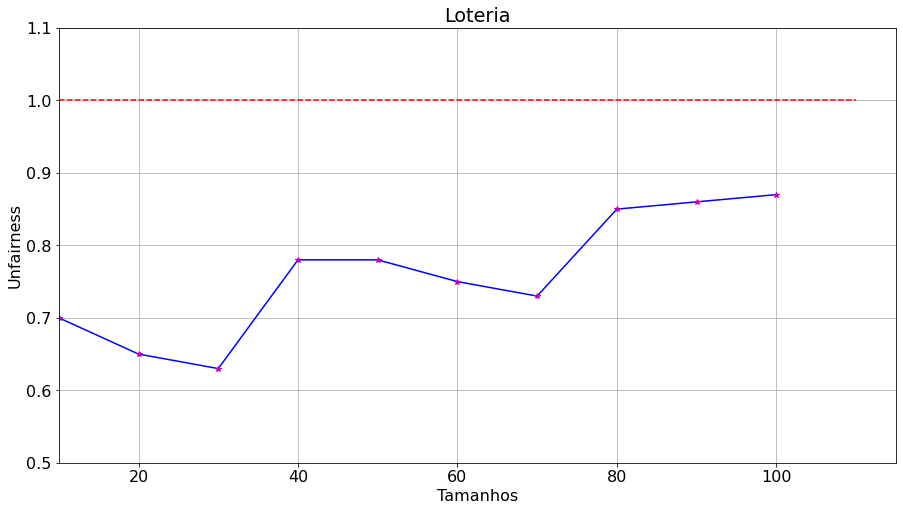

In [122]:
plt.figure(figsize=(15,8))
plt.rc('font',size=16)
plt.ylabel("Unfairness")
plt.title("Loteria")
plt.xlabel("Tamanhos")
plt.grid()
plt.ylim(0.7)

plt.xlim((tamanhos[0],tamanhos[-1]+15))

plt.yticks([i/10 for i in range(5,12)])

plt.plot(tamanhos,unfairnesses,'b')
plt.plot([tamanhos[0],tamanhos[-1]+10],[1,1],'r--')
plt.plot(tamanhos,unfairnesses,'m*')
plt.show()

4 - Rode o simulador maior com três tipos de processo possíveis: um com 10 tickets, um com 20 e um com 50. O que aconteceu com os que receberam menos tickets? Eles tiveram chance de rodar?

<b> R: Os processos A e B alternaram no simulador, o processador C só rodou quando os dois primeiros processos terminaram. <b/>

In [123]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(3, ['A','B', 'C'], [0,0,0], np.array([10,10,10]), [50,20,10])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("loteria", procs, 2, 0)

################# LOTERIA ######################

 Premiado = 49
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |

 Premiado = 53
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 2 |

 Premiado = 33
A  rodou por  2  timeslice, faltam  6

 Premiado = 62
B  rodou por  2  timeslice, faltam  6

 Premiado = 38
A  rodou por  2  timeslice, faltam  4

 Premiado = 45
A  rodou por  2  timeslice, faltam  2

 Premiado = 27
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 14 | 


 Premiado = 4
B  rodou por  2  timeslice, faltam  4

 Premiado = 4
B  rodou por  2  timeslice, faltam  2

 Premiado = 3
B  rodou por  2  timeslice, faltam  0
| Tempo de Execução(B) = 20 | 


 Premiado = 4
C  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(C) = 20 |

 Premiado = 9
C  rodou por  2  timeslice, faltam  6

 Premiado = 4
C  rodou por  2  timeslice, faltam  4

 Premiado = 1
C  rodou por  2  timeslice, faltam  2

 Premiado = 5
C  rodou por  2  timeslice, faltam 

#### Sobre Stride ####

1 - Repita o cenário da 2 de loteria e faça um novo gráfico.



In [124]:
tamanhos = []
unfairnesses = []
for i in range(10):
    #chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets
    procs = chamaProcs(2, ['A','B'], [0,0], np.array([(i+1)*10]*2), [100,100])
    tamanhos.append((i+1)*10)

    #escalonar recebe nome do escalonador, processos, quantum e timeslice
    rm, unfairness = escalonar("stride", procs, 2, 0)
    unfairnesses.append(unfairness)

################# STRIDE ######################
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 2 |
A  rodou por  2  timeslice, faltam  6
B  rodou por  2  timeslice, faltam  6
A  rodou por  2  timeslice, faltam  4
B  rodou por  2  timeslice, faltam  4
A  rodou por  2  timeslice, faltam  2
B  rodou por  2  timeslice, faltam  2
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 18 | 

B  rodou por  2  timeslice, faltam  0
| Tempo de Execução(B) = 20 | 

Turnaround = 19.0
Tempo de resposta = 1.0
################# STRIDE ######################
A  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(A) = 0 |
B  rodou por  2  timeslice, faltam  18
| Tempo de Resposta(B) = 2 |
A  rodou por  2  timeslice, faltam  16
B  rodou por  2  timeslice, faltam  16
A  rodou por  2  timeslice, faltam  14
B  rodou por  2  timeslice, faltam  14
A  rodou por  2  timeslice, faltam  12
B  rodou por  2  timeslice, f

A  rodou por  2  timeslice, faltam  36
B  rodou por  2  timeslice, faltam  36
A  rodou por  2  timeslice, faltam  34
B  rodou por  2  timeslice, faltam  34
A  rodou por  2  timeslice, faltam  32
B  rodou por  2  timeslice, faltam  32
A  rodou por  2  timeslice, faltam  30
B  rodou por  2  timeslice, faltam  30
A  rodou por  2  timeslice, faltam  28
B  rodou por  2  timeslice, faltam  28
A  rodou por  2  timeslice, faltam  26
B  rodou por  2  timeslice, faltam  26
A  rodou por  2  timeslice, faltam  24
B  rodou por  2  timeslice, faltam  24
A  rodou por  2  timeslice, faltam  22
B  rodou por  2  timeslice, faltam  22
A  rodou por  2  timeslice, faltam  20
B  rodou por  2  timeslice, faltam  20
A  rodou por  2  timeslice, faltam  18
B  rodou por  2  timeslice, faltam  18
A  rodou por  2  timeslice, faltam  16
B  rodou por  2  timeslice, faltam  16
A  rodou por  2  timeslice, faltam  14
B  rodou por  2  timeslice, faltam  14
A  rodou por  2  timeslice, faltam  12
B  rodou por  2  timeslic

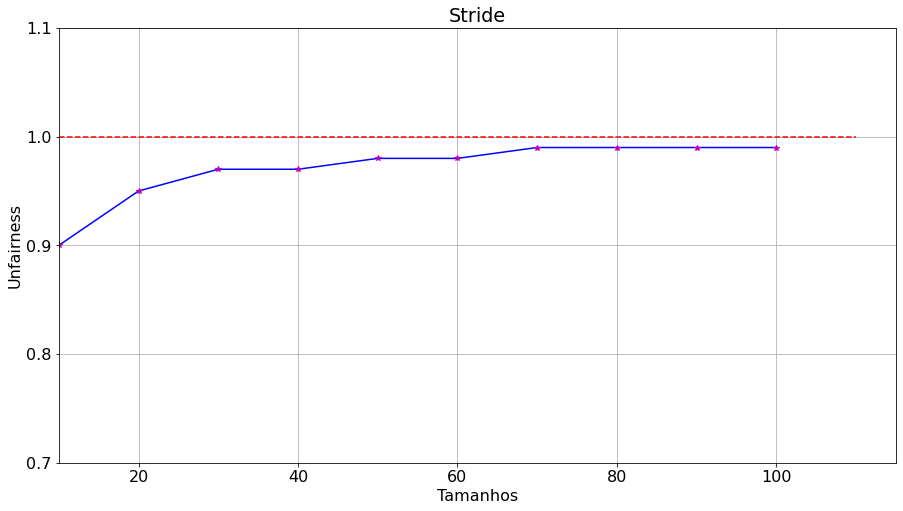

In [125]:
plt.figure(figsize=(15,8))
plt.rc('font',size=16)
plt.ylabel("Unfairness")
plt.title("Stride")
plt.xlabel("Tamanhos")
plt.grid()
plt.ylim(0.7)

plt.xlim((tamanhos[0],tamanhos[-1]+15))

plt.yticks([i/10 for i in range(7,12)])

plt.plot(tamanhos,unfairnesses,'b')
plt.plot([tamanhos[0],tamanhos[-1]+10],[1,1],'r--')
plt.plot(tamanhos,unfairnesses,'m*')
plt.show()

2 - No simulador maior, qual o efeito que ter muitos processos fazendo E/S tem no algoritmo? O que pode ser feito com a posição do processo quando ele volta de E/S?

<b> R: O efeito de ter muitos processos fazendo E/S faz com que esses demorem mais que os outros para terminar, mesmo tendo o mesmo número de tickets (por exemplo 10 tickets). As posiçoes dos processam alternam de acordo com a prioridade após o E/S, o que pode acontecer de que processos que estão por ultimo ou no meio da fila de processos possam ser rodados antes.<b/>


In [126]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(5, ['A','B', 'C', 'D', 'E'], [1,0,1,0,1], 
                   np.array([10,10,10,10,10]),[10,10,10,10,10])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("loteria", procs, 2, 0)

################# LOTERIA ######################

 Premiado = 24
C  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(C) = 0 |

 Premiado = 26
C  rodou por  2  timeslice, faltam  6

 Premiado = 16
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 4 |

 Premiado = 31
D  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(D) = 6 |

 Premiado = 19
B  rodou por  2  timeslice, faltam  6

 Premiado = 22
C  rodou por  2  timeslice, faltam  4

 Premiado = 13
B  rodou por  2  timeslice, faltam  4

 Premiado = 8
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 14 |

 Premiado = 8
A  rodou por  2  timeslice, faltam  6

 Premiado = 6
A  rodou por  2  timeslice, faltam  4

 Premiado = 16
B  rodou por  2  timeslice, faltam  2

 Premiado = 45
E  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(E) = 22 |

 Premiado = 9
A  rodou por  2  timeslice, faltam  2

 Premiado = 6
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 28 | 


 Premiado = 4
B  rod

3 - No simulador maior, rode um cenário igual para stride e loteria (com a mesma semente aleatória) e calcule tempo de resposta, de execução e __tempo de espera__ (tempo que o processo passou pronto). O que mudou entre os dois?

<b>R: O tempo de resposta do Stride é consideravelmente menor (2.0) do que o tempo de resposta da Loteria (7.3) e as duas métricas também são melhores no Stride, mas são mais próximas aos resultados da Loteria.<b/>

In [127]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(3, ['A','B', 'C'], [1,1,1], np.array([10,10,10]), [50,20,10])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("stride", procs, 2, 0)

################# STRIDE ######################
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 2 |
C  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(C) = 4 |
A  rodou por  2  timeslice, faltam  6
A  rodou por  2  timeslice, faltam  4
B  rodou por  2  timeslice, faltam  6
A  rodou por  2  timeslice, faltam  2
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 16 | 

B  rodou por  2  timeslice, faltam  4
C  rodou por  2  timeslice, faltam  6
B  rodou por  2  timeslice, faltam  2
B  rodou por  2  timeslice, faltam  0
| Tempo de Execução(B) = 24 | 

C  rodou por  2  timeslice, faltam  4
C  rodou por  2  timeslice, faltam  2
C  rodou por  2  timeslice, faltam  0
| Tempo de Execução(C) = 30 | 

Turnaround = 23.333333333333332
Tempo de resposta = 2.0


In [128]:
#chamaprocs recebe qtd de processos, o nome dos processos, chanceio, tamanho e tickets 
procs = chamaProcs(3, ['A','B', 'C'], [1,1,1], np.array([10,10,10]), [50,20,10])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("loteria", procs, 2, 0)

################# LOTERIA ######################

 Premiado = 49
A  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(A) = 0 |

 Premiado = 53
B  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(B) = 2 |

 Premiado = 33
A  rodou por  2  timeslice, faltam  6

 Premiado = 62
B  rodou por  2  timeslice, faltam  6

 Premiado = 38
A  rodou por  2  timeslice, faltam  4

 Premiado = 45
A  rodou por  2  timeslice, faltam  2

 Premiado = 27
A  rodou por  2  timeslice, faltam  0
| Tempo de Execução(A) = 14 | 


 Premiado = 4
B  rodou por  2  timeslice, faltam  4

 Premiado = 4
B  rodou por  2  timeslice, faltam  2

 Premiado = 3
B  rodou por  2  timeslice, faltam  0
| Tempo de Execução(B) = 20 | 


 Premiado = 4
C  rodou por  2  timeslice, faltam  8
| Tempo de Resposta(C) = 20 |

 Premiado = 9
C  rodou por  2  timeslice, faltam  6

 Premiado = 4
C  rodou por  2  timeslice, faltam  4

 Premiado = 1
C  rodou por  2  timeslice, faltam  2

 Premiado = 5
C  rodou por  2  timeslice, faltam 

#### Sobre MLFQ ####

1 - Rode o MLFQ no segundo simulador com duas filas e sem boost. O que aconteceu? 



In [134]:
procs = chamaProcs(2, ['A','B'], [0,0], np.array([10,10]), [10,10])

#escalonar recebe nome do escalonador, processos, quantum e timeslice
rm, unfairness = escalonar("mlfq", procs, 0, 0)

################# MLFQ ######################
A  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(A) = 0 |
B  rodou por  1  timeslice, faltam  9
| Tempo de Resposta(B) = 1 |
A  rodou por  1  timeslice, faltam  8
B  rodou por  1  timeslice, faltam  8
A  rodou por  1  timeslice, faltam  7
B  rodou por  1  timeslice, faltam  7
A  rodou por  1  timeslice, faltam  6
B  rodou por  1  timeslice, faltam  6
A  rodou por  1  timeslice, faltam  5
B  rodou por  1  timeslice, faltam  5
A  rodou por  1  timeslice, faltam  4
B  rodou por  1  timeslice, faltam  4
A  rodou por  1  timeslice, faltam  3
B  rodou por  1  timeslice, faltam  3
A  rodou por  1  timeslice, faltam  2
B  rodou por  1  timeslice, faltam  2
A  rodou por  1  timeslice, faltam  1
B  rodou por  1  timeslice, faltam  1
A  rodou por  1  timeslice, faltam  0
| Tempo de Execução(A) = 19 | 

B  rodou por  1  timeslice, faltam  0
| Tempo de Execução(B) = 20 | 



IndexError: list index out of range

2 - Quais configurações de parâmetros transformam o MLFQ no Round Robin?

<b> Quando o MLFQ possui uma única lista. <b/>


3 - Rodando no primeiro simulador, faça 1 dos quatro processos ser 100\% CPU-Bound e os outros três 60\% I/O Bound. Use a configuração com 3 filas, com 5, 3 e 1 timeslices para as fila em ordem de priorida. De quanto tempo deve ser o Boost para que o processo CPU-Bound não sofra starvation e tenha CPU 1 vez a cada 20 timeslices?

4 - Teste diversas configurações de número de filas, quantum das filas e boost no simulador maior e ache a que leva ao melhor tempo de execução.